In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot



=== 1) Parsing dates & ensuring numeric ===

=== 2) Basic info ===
train shape: (7340, 18)
train columns: ['warehouse', 'date', 'orders', 'holiday_name', 'holiday', 'shutdown', 'mini_shutdown', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id']
train date range: 2020-12-05 00:00:00 -> 2024-03-15 00:00:00
unique warehouses: 7
warehouse ids: ['Prague_1' 'Brno_1' 'Prague_2' 'Prague_3' 'Munich_1' 'Frankfurt_1'
 'Budapest_1']

=== 3) Per-warehouse statistics ===
            count         mean          std     min      max
warehouse                                                   
Prague_1     1193  8535.336966  1215.982528  3754.0  18139.0
Brno_1       1193  7274.532272   962.283379  4203.0  11741.0
Budapest_1   1154  5555.864818   688.113844  3897.0   8779.0
Prague_2     1193  5142.093043   693.820944  2295.0  10004.0
Prague_3     1193  4705.911148   607.034011 

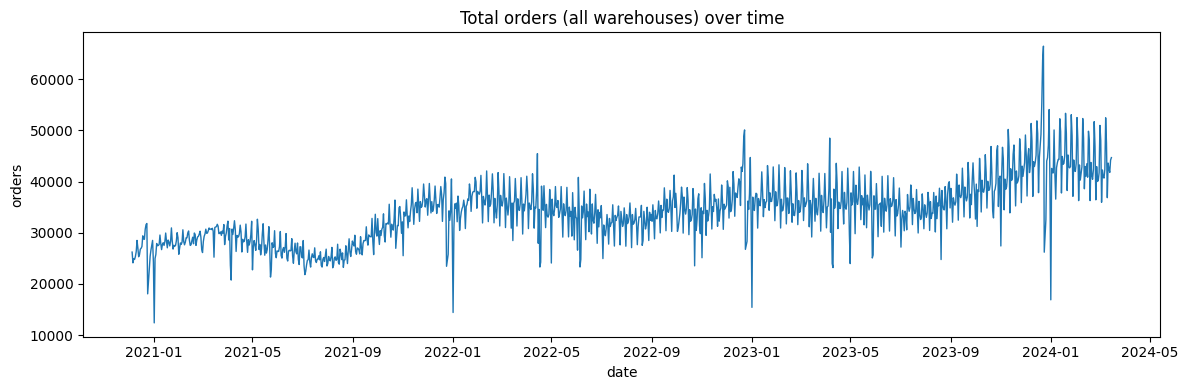


=== 5) Distribution of orders (global) ===


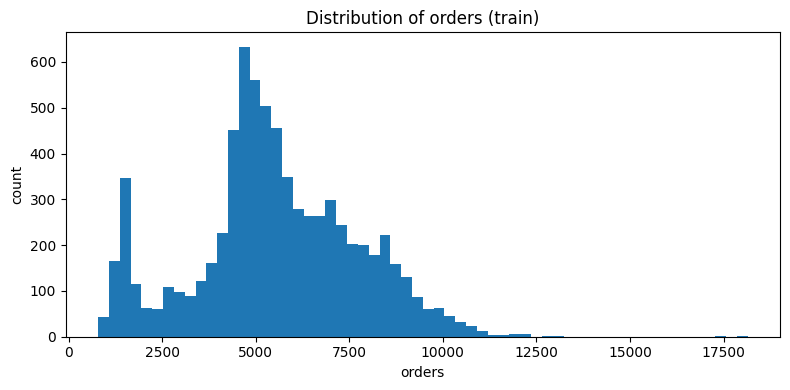


=== 6) Daily orders per warehouse ===


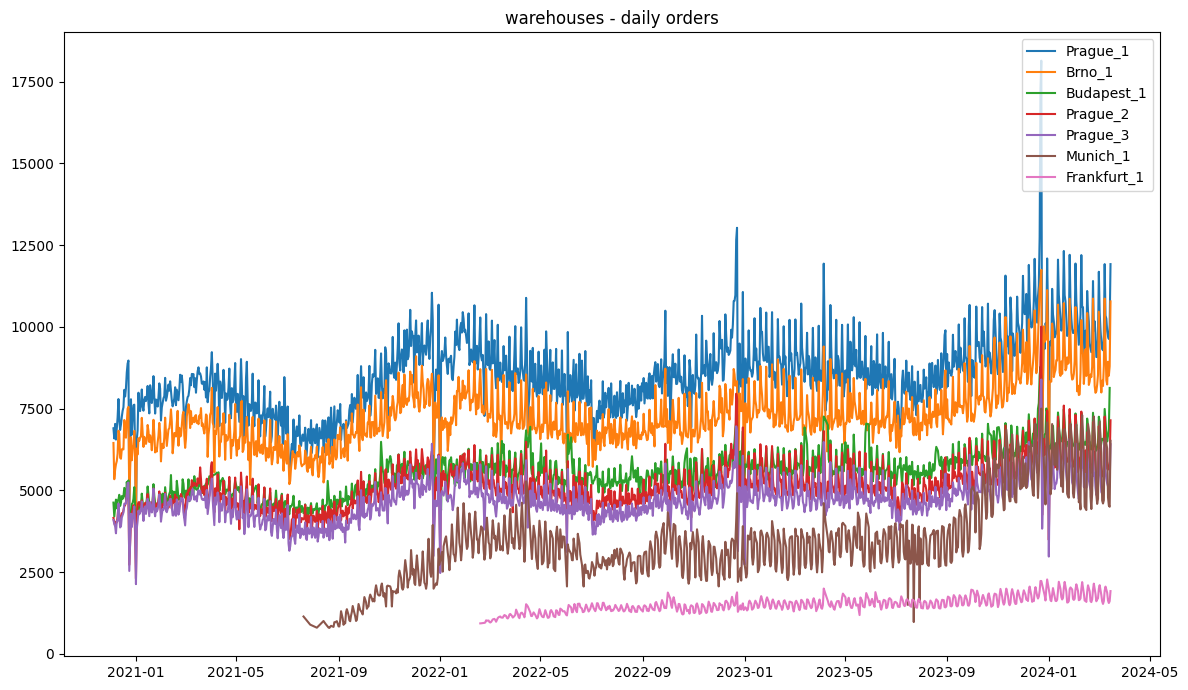


=== 7) Boxplot per top warehouse (outliers clipped) ===


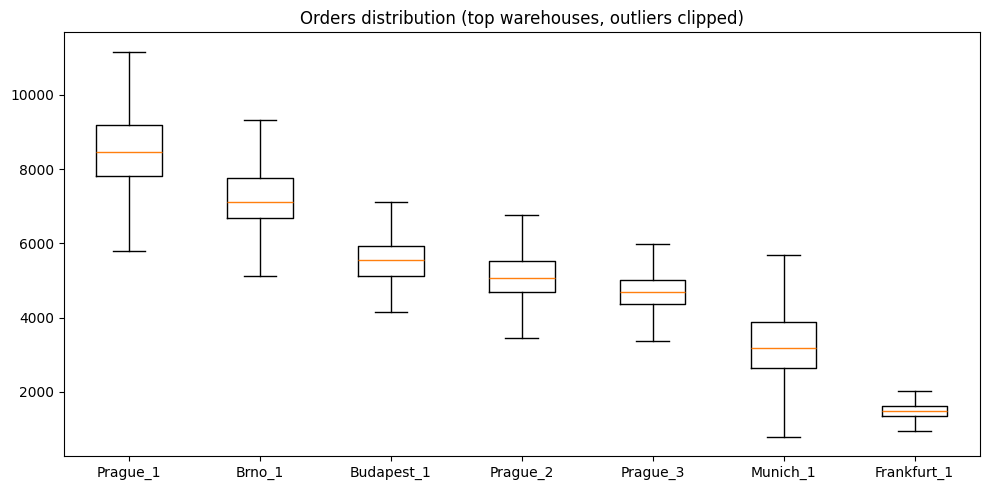


=== 8) Day-of-week effect (overall) ===


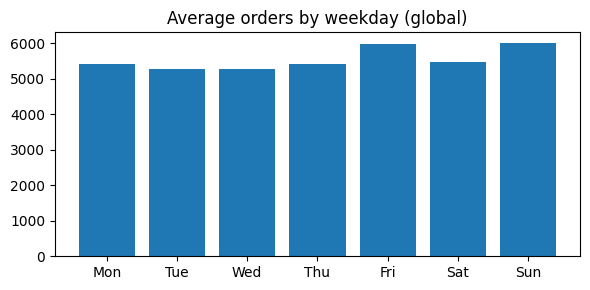

Avg orders by weekday:
 weekday
0    5429.757547
1    5290.045161
2    5265.436929
3    5409.439853
4    5980.102304
5    5469.622120
6    6010.328979
Name: orders, dtype: float64

=== 9) Weekday patterns per top warehouse ===


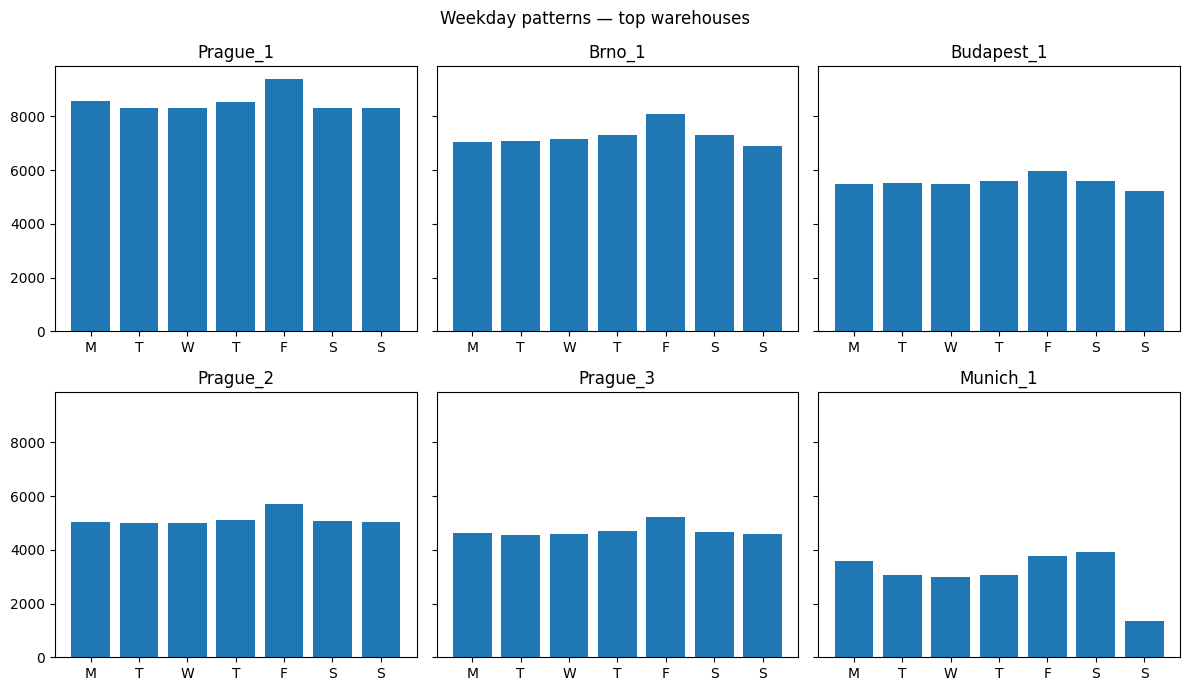


=== 10) Holiday effect ===
Avg orders on holiday vs non-holiday:
         count         mean          std
holiday                                 
0         7140  5528.866807  2185.542947
1          200  5770.245000  2069.413403


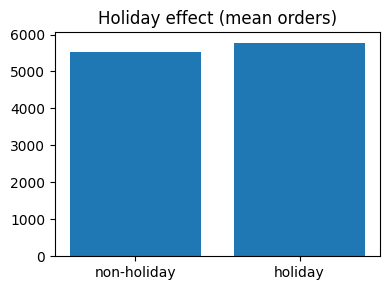


=== 11) Other event effects (shops_closed, school_holidays, etc.) ===
Mean orders by shops_closed (0/1):
 shops_closed
0    5527.465427
1    6259.487500
Name: orders, dtype: float64
Mean orders by winter_school_holidays (0/1):
 winter_school_holidays
0    5505.821910
1    6494.118182
Name: orders, dtype: float64
Mean orders by school_holidays (0/1):
 school_holidays
0    5554.814352
1    2820.596154
Name: orders, dtype: float64
Mean orders by shutdown (0/1):
 shutdown
0    5535.498706
1    5133.000000
Name: orders, dtype: float64
Mean orders by mini_shutdown (0/1):
 mini_shutdown
0    5535.55289
1    5335.50000
Name: orders, dtype: float64
Mean orders by blackout (0/1):
 blackout
0    5537.101186
1    3799.285714
Name: orders, dtype: float64
Mean orders by frankfurt_shutdown (0/1):
 frankfurt_shutdown
0    5536.585991
1    1345.000000
Name: orders, dtype: float64

=== 12) Numeric feature correlations ===
Correlation matrix:
                    orders  precipitation      snow  mov_chan

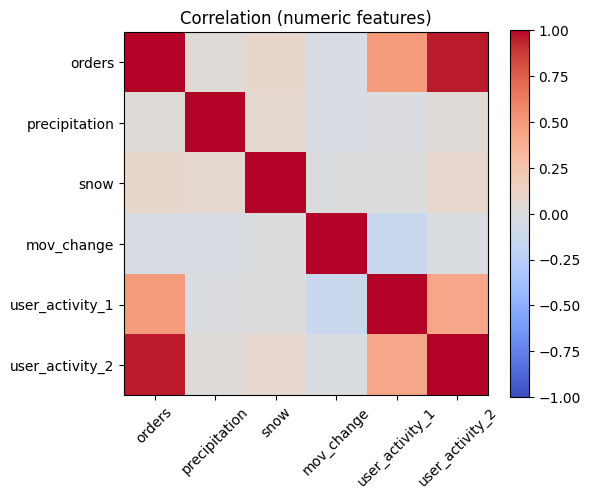


=== 13) Autocorrelation plot for sample warehouse ===


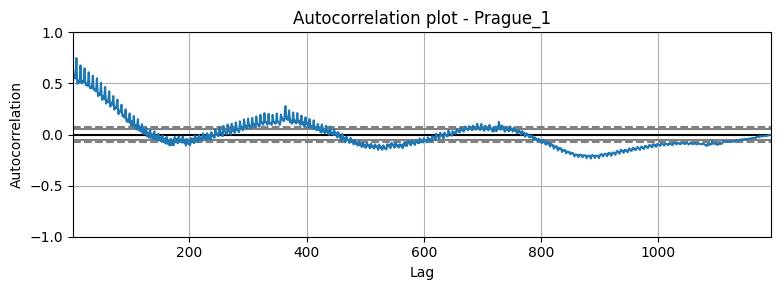


=== 14) Quick anomalies / spikes (z-score > 3) ===
Dates with z-score > 3 (global spikes):
           date   orders    zscore
1108 2023-12-21  55283.0  3.456342
1109 2023-12-22  63688.0  4.824981
1110 2023-12-23  66438.0  5.272781
1116 2023-12-30  54055.0  3.256379
1136 2024-01-19  53323.0  3.137183
1143 2024-01-26  53049.0  3.092566
1150 2024-02-02  52492.0  3.001866


In [65]:
train = pd.read_csv(r"..\data\forecast\train.csv")
train_cal = pd.read_csv(r"..\data\forecast\train_calendar.csv")

# 1) parse dates & ensure numeric
print("\n=== 1) Parsing dates & ensuring numeric ===")
train['date'] = pd.to_datetime(train['date'], errors='coerce')
train_cal['date'] = pd.to_datetime(train_cal['date'], errors='coerce')
train['orders'] = pd.to_numeric(train['orders'], errors='coerce')

# drop truly invalid rows (if any)
train = train.dropna(subset=['date']).reset_index(drop=True)
train = train.dropna(subset=['orders']).reset_index(drop=True)

# 2) Quick summary prints
print("\n=== 2) Basic info ===")
print("train shape:", train.shape)
print("train columns:", list(train.columns))
print("train date range:", train['date'].min(), "->", train['date'].max())
print("unique warehouses:", train['warehouse'].nunique())
print("warehouse ids:", train['warehouse'].unique()[:10])

# 3) Per-warehouse stats
print("\n=== 3) Per-warehouse statistics ===")
wh_stats = train.groupby("warehouse")['orders'].agg(
    ['count','mean','std','min','max']
).sort_values('mean', ascending=False)
print(wh_stats.head())

# 4) Total demand over time (all warehouses)
print("\n=== 4) Total orders over time (all warehouses) ===")
daily_total = train.groupby('date')['orders'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily_total['date'], daily_total['orders'], lw=1)
plt.title("Total orders (all warehouses) over time")
plt.xlabel("date"); plt.ylabel("orders")
plt.tight_layout(); plt.show()

# 5) Distribution of orders (global)
print("\n=== 5) Distribution of orders (global) ===")
plt.figure(figsize=(8,4))
plt.hist(train['orders'], bins=60)
plt.title("Distribution of orders (train)")
plt.xlabel("orders"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# 6) Warehouses time-series 
print("\n=== 6) Daily orders per warehouse ===")
top_wh = wh_stats.index.to_list()
plt.figure(figsize=(12,7))
for w in top_wh:
    s = train[train['warehouse']==w].groupby('date')['orders'].sum().sort_index()
    plt.plot(s.index, s.values, label=w)
plt.legend(loc='upper right'); plt.title("warehouses - daily orders")
plt.tight_layout(); plt.show()

# 7) Boxplot per top warehouse (shows spread & outliers)
print("\n=== 7) Boxplot per top warehouse (outliers clipped) ===")
plt.figure(figsize=(10,5))
data = [train[train['warehouse']==w]['orders'].values for w in top_wh]
plt.boxplot(data, tick_labels=top_wh, showfliers=False)
plt.title("Orders distribution (top warehouses, outliers clipped)")
plt.tight_layout(); plt.show()

# 8) Day-of-week effect (overall)
print("\n=== 8) Day-of-week effect (overall) ===")
train['weekday'] = train['date'].dt.weekday  # 0=Mon..6=Sun
dow = train.groupby('weekday')['orders'].mean()
plt.figure(figsize=(6,3))
plt.bar(dow.index, dow.values)
plt.xticks(dow.index, ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Average orders by weekday (global)")
plt.tight_layout(); plt.show()
print("Avg orders by weekday:\n", dow)

# 9) Day-of-week per warehouse (small grid)
print("\n=== 9) Weekday patterns per top warehouse ===")
fig, axes = plt.subplots(2,3, figsize=(12,7), sharey=True)
axes = axes.flatten()
for ax,w in zip(axes, top_wh):
    d = train[train['warehouse']==w].groupby('weekday')['orders'].mean()
    ax.bar(d.index, d.values)
    ax.set_title(w)
    ax.set_xticks(range(7)); ax.set_xticklabels(['M','T','W','T','F','S','S'])
fig.suptitle("Weekday patterns — top warehouses")
plt.tight_layout(); plt.show()

# 10) Holiday effect (global)
if 'holiday' in train.columns:
    print("\n=== 10) Holiday effect ===")
    print("Avg orders on holiday vs non-holiday:")
    print(train.groupby('holiday')['orders'].agg(['count','mean','std']))
    # quick bar
    hmean = train.groupby('holiday')['orders'].mean()
    plt.figure(figsize=(4,3)); plt.bar(['non-holiday','holiday'], hmean.values); plt.title("Holiday effect (mean orders)"); plt.tight_layout(); plt.show()

# 11) Other boolean event effects
print("\n=== 11) Other event effects (shops_closed, school_holidays, etc.) ===")
event_cols = [c for c in ['shops_closed','winter_school_holidays','school_holidays','shutdown','mini_shutdown','blackout','frankfurt_shutdown'] if c in train.columns]
for c in event_cols:
    g = train.groupby(c)['orders'].mean()
    print(f"Mean orders by {c} (0/1):\n", g)

# 12) Numerical feature correlations
print("\n=== 12) Numeric feature correlations ===")
num_cols = [c for c in ['orders','precipitation','snow','mov_change','user_activity_1','user_activity_2'] if c in train.columns]
if len(num_cols) > 1:
    corr = train[num_cols].corr()
    print("Correlation matrix:\n", corr)
    plt.figure(figsize=(6,5)); plt.imshow(corr, interpolation='none', cmap='coolwarm', vmin=-1, vmax=1); plt.colorbar(); plt.xticks(range(len(num_cols)), num_cols, rotation=45); plt.yticks(range(len(num_cols)), num_cols); plt.title("Correlation (numeric features)"); plt.tight_layout(); plt.show()

# 13) Autocorrelation check for 1-2 representative warehouses
print("\n=== 13) Autocorrelation plot for sample warehouse ===")
sample_wh = top_wh[0] if len(top_wh)>0 else train['warehouse'].unique()[0]
series = train[train['warehouse']==sample_wh].groupby('date')['orders'].sum().sort_index()
plt.figure(figsize=(8,3)); autocorrelation_plot(series); plt.title(f"Autocorrelation plot - {sample_wh}"); plt.tight_layout(); plt.show()

# 14) Quick anomalies / spikes (global)
print("\n=== 14) Quick anomalies / spikes (z-score > 3) ===")
daily_total['zscore'] = (daily_total['orders'] - daily_total['orders'].mean()) / daily_total['orders'].std()
spikes = daily_total[daily_total['zscore']>3]
print("Dates with z-score > 3 (global spikes):")
print(spikes[['date','orders','zscore']])


In [68]:
train_cal.columns

Index(['date', 'holiday_name', 'holiday', 'shutdown', 'mini_shutdown',
       'warehouse_limited', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'warehouse'],
      dtype='object')

In [69]:
import pandas as pd
import numpy as np

# --- 1) Load train data ---
train = pd.read_csv(r"..\data\forecast\train.csv")
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(['warehouse','date']).reset_index(drop=True)

# --- 2) Define validation period ---
validation_days = 14
last_date = train['date'].max()
val_start = last_date - pd.Timedelta(days=validation_days-1)

# Split train/validation
train_base = train[train['date'] < val_start]
val = train[train['date'] >= val_start]

# --- 3) Seasonal Naive Forecast ---
def seasonal_naive_forecast(train_df, val_df, season=7):
    forecast_list = []
    for wh in train_df['warehouse'].unique():
        wh_train = train_df[train_df['warehouse']==wh].set_index('date')
        wh_val = val_df[val_df['warehouse']==wh].copy()
        wh_val['orders_pred'] = wh_val['date'].apply(
            lambda x: wh_train.loc[x - pd.Timedelta(days=season),'orders']
            if (x - pd.Timedelta(days=season)) in wh_train.index
            else wh_train['orders'].iloc[-season]
        )
        forecast_list.append(wh_val)
    return pd.concat(forecast_list)

val_sn = seasonal_naive_forecast(train_base, val)

# --- 4) Rolling Mean Forecast ---
def rolling_mean_forecast(train_df, val_df, window=7):
    forecast_list = []
    for wh in train_df['warehouse'].unique():
        wh_train = train_df[train_df['warehouse']==wh].set_index('date')
        wh_val = val_df[val_df['warehouse']==wh].copy()
        rolling_mean = wh_train['orders'].rolling(window).mean().iloc[-1]
        wh_val['orders_pred'] = rolling_mean
        forecast_list.append(wh_val)
    return pd.concat(forecast_list)

val_rm = rolling_mean_forecast(train_base, val, window=7)

# --- 5) Evaluate Baselines ---
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")

evaluate(val_sn['orders'], val_sn['orders_pred'], "Seasonal Naive")
evaluate(val_rm['orders'], val_rm['orders_pred'], "Rolling Mean")

# --- 6) Prepare submission for Kaggle test ---
# test = pd.read_csv("test.csv")
# For now, we just show structure
# submission = test[['id']].copy()
# submission['orders'] = seasonal_naive_forecast(train, test)['orders_pred']
# submission.to_csv("submission_seasonal_naive.csv", index=False)


Seasonal Naive → RMSE: 585.75, MAE: 351.24
Rolling Mean → RMSE: 707.69, MAE: 495.31
